In [190]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from rank_bm25 import BM25Okapi
import numpy as np

# Data prep

In [191]:
filtered_merged_df=pd.read_csv('../Data/top1000_dev_with_labels.tsv')

In [192]:
filtered_merged_df

,qid,pid,query,passage,Q0,relevance
0,188714,1000052,foods and supplements to lower blood sugar,Watch portion sizes: ■ Even healthy foods will...,NaN,0
1,1082792,1000084,what does the golgi apparatus do to the protei...,"Start studying Bonding, Carbs, Proteins, Lipid...",NaN,0
2,995526,1000094,where is the federal penitentiary in ind,It takes THOUSANDS of Macy's associates to bri...,NaN,0
3,660957,1000115,what foods are good if you have gout?,The good news is that you will discover what g...,NaN,0
4,837202,1000252,what is the nutritional value of oatmeal,"Oats make an easy, balanced breakfast. One cup...",NaN,0
...,...,...,...,...,...,...
5467373,1067772,999933,what is a sabbatical policy for nonprofit,Corporate Records for Nonprofit Corporations. ...,NaN,0
5467374,679360,999933,what is a corporate bylaws,Corporate Records for Nonprofit Corporations. ...,NaN,0
5467375,36388,999956,average family savings account,When it comes to average retirement savings st...,NaN,0
5467376,43781,999956,average savings per age group,When it comes to average retirement savings st...,NaN,0


In [193]:
qid_df = filtered_merged_df[['qid','query']].drop_duplicates()
qid_df

,qid,query
0,188714,foods and supplements to lower blood sugar
1,1082792,what does the golgi apparatus do to the protei...
2,995526,where is the federal penitentiary in ind
3,660957,what foods are good if you have gout?
4,837202,what is the nutritional value of oatmeal
...,...,...
1734887,987978,where is miralago
1737934,860942,what is viastone
2335215,978057,where is berrimah
3143571,999518,where is azaz


In [194]:
passage_df = filtered_merged_df[['pid','passage']].drop_duplicates()
passage_df

,pid,passage
0,1000052,Watch portion sizes: ■ Even healthy foods will...
1,1000084,"Start studying Bonding, Carbs, Proteins, Lipid..."
2,1000094,It takes THOUSANDS of Macy's associates to bri...
3,1000115,The good news is that you will discover what g...
4,1000252,"Oats make an easy, balanced breakfast. One cup..."
...,...,...
5467365,999808,They invented the 365-day calendar. They used ...
5467366,999824,The current average NBA salary of $6.2 million...
5467371,999890,Examples of conformal coating capillary flow E...
5467373,999933,Corporate Records for Nonprofit Corporations. ...


In [ ]:
qid_df.to_csv('qid_query_map.csv')

In [95]:
passage_df.to_csv('pid_passage_token.csv')

In [96]:
qid_df = pd.read_csv('../Data/qid_query_map.csv')
qid_df

,Unnamed: 0,qid,query
0,0,188714,foods and supplements to lower blood sugar
1,1,1082792,what does the golgi apparatus do to the protei...
2,2,995526,where is the federal penitentiary in ind
3,3,660957,what foods are good if you have gout?
4,4,837202,what is the nutritional value of oatmeal
...,...,...,...
5733,1734887,987978,where is miralago
5734,1737934,860942,what is viastone
5735,2335215,978057,where is berrimah
5736,3143571,999518,where is azaz


In [195]:
passage_df = pd.read_csv('../Data/pid_passage_token.csv')

In [196]:
passage_df

,Unnamed: 0,pid,passage,tokenized_passage
0,0,1000052,Watch portion sizes: ■ Even healthy foods will...,"['watch', 'portion', 'sizes:', '■', 'even', 'h..."
1,1,1000084,"Start studying Bonding, Carbs, Proteins, Lipid...","['start', 'studying', 'bonding,', 'carbs,', 'p..."
2,2,1000094,It takes THOUSANDS of Macy's associates to bri...,"['it', 'takes', 'thousands', 'of', ""macy's"", '..."
3,3,1000115,The good news is that you will discover what g...,"['the', 'good', 'news', 'is', 'that', 'you', '..."
4,4,1000252,"Oats make an easy, balanced breakfast. One cup...","['oats', 'make', 'an', 'easy,', 'balanced', 'b..."
...,...,...,...,...
3429674,5467365,999808,They invented the 365-day calendar. They used ...,"['they', 'invented', 'the', '365-day', 'calend..."
3429675,5467366,999824,The current average NBA salary of $6.2 million...,"['the', 'current', 'average', 'nba', 'salary',..."
3429676,5467371,999890,Examples of conformal coating capillary flow E...,"['examples', 'of', 'conformal', 'coating', 'ca..."
3429677,5467373,999933,Corporate Records for Nonprofit Corporations. ...,"['corporate', 'records', 'for', 'nonprofit', '..."


# BM 25

In [197]:

queries = filtered_merged_df['query'].unique()


filtered_merged_df['bm25_score'] = None

for query in tqdm(queries, desc='Calculating BM25 scores', unit='query'):
    # Filter passages for the current query
    passages = filtered_merged_df[filtered_merged_df['query'] == query]['passage'].tolist()

    # Tokenize passages and query
    passages_tokenized = [passage.lower().split() for passage in passages]
    query_tokenized = query.lower().split()

    # Create BM25 index
    bm25 = BM25Okapi(passages_tokenized, k1=0.9, b=0.4)

    # Calculate BM25 scores
    scores = bm25.get_scores(query_tokenized)
    #print(len(scores))
    # Update the DataFrame with BM25 scores
    filtered_merged_df.loc[filtered_merged_df['query'] == query, 'bm25_score'] = scores

Calculating BM25 scores: 100%|██████████| 5738/5738 [25:49<00:00,  3.70query/s]


In [198]:
filtered_merged_df.to_csv('../Data/top_1000_BM_score_1.csv')

# MRR

In [199]:
filtered_merged_df['rank_BM'] = filtered_merged_df.groupby('qid')['bm25_score'].rank(ascending=False).astype(int)

In [204]:
total_mrr = 0.0
r=[]

for unique_id in filtered_merged_df['qid'].unique():

    current_id_df = filtered_merged_df[filtered_merged_df['qid'] == unique_id]

    current_id_df = current_id_df.sort_values(by='rank_BM')

    rank_first_relevant = current_id_df.loc[current_id_df['relevance'] == 1, 'rank_BM'].min()

    mrr = 1 / rank_first_relevant if pd.notnull(rank_first_relevant) else 0
    
    # Set number of documents to consider rank_first_relevant<10, 1000 default
    if rank_first_relevant<100:

        total_mrr += mrr
    r.append(rank_first_relevant)

# Calculate Mean Reciprocal Rank
mean_mrr = total_mrr / len(filtered_merged_df['qid'].unique())


In [203]:
mean_mrr

0.12154219199519498

(array([3074.,  727.,  378.,  312.,  285.,  232.,  244.,  180.,  154.,
         152.]),
 array([   1. ,  100.9,  200.8,  300.7,  400.6,  500.5,  600.4,  700.3,
         800.2,  900.1, 1000. ]),
 <BarContainer object of 10 artists>)

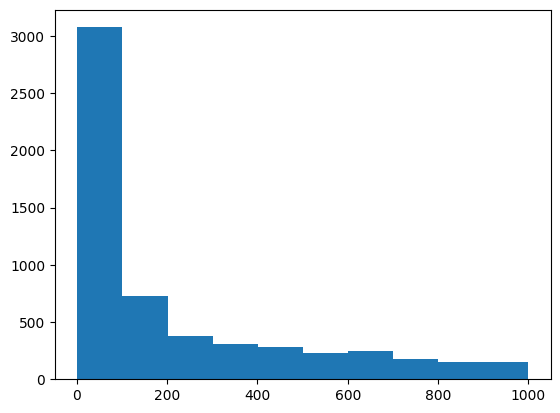

: 

In [209]:
import matplotlib.pyplot as plt
plt.hist(r)